# Construisez un modèle de scoring

## Problématique métier

L'objectif est de construire et comparer les performances de plusieurs modèles de scoring déterminants la capacité d'un emprunteur à rembourser un prêt. Ces modèles doivent être facilement interprétables car ils s'adressent à notre client, une société financière nommée "Prêt à dépenser". Une mesure de l'importance des variables sera réalisée pour que le client puisse analyser a posteriori la contribution des différentes variables retenues.

## Description du jeu de données

**Le jeu de données provient de Home Credit, une société financière fournissant des prêts à des personnes qui disposent de peu d'historique. Les données sont partitionnées dans les fichiers suivants:**

* application_{train|test}.csv:

  Il s'agit des tables principales: une ligne correspond à un prêt. Les données sont séparées en jeux d'entraînement et de test.


* bureau.csv

  Historique disponible des anciens prêts accordés aux individus de notre échantillon.
  Chaque ligne correspond à un ancien prêts.


* bureau_balance.csv

  Il s'agit de l'historique individuel mensuel de chaque emprunt présent dans bureau.csv.
  Chaque ligne correspond à un mois d'historique d'un emprunt.


* POS_CASH_balance.csv

  Historique du solde mensuel des emprunteurs de notre échantillon.
  Chaque ligne correspond à un mois d'historique d'un prêt.
  

* credit_card_balance.csv

  Historique du solde mensuel des cartes de crédit des clients de Home Credit présents dans notre échantillon.
  Chaque ligne correspond à un mois d'historique d'un compte.


* previous_application.csv

  Historique des demandes d'emprunt (acceptées ou non).
  Une ligne correspond à une demande.


* installments_payments.csv

  Historique des versements des crédit précedemment attribués.
  Une ligne correspond à un versement.


* HomeCredit_columns_description.csv

  Description de chaque colonne de chaque fichier.

<br>


**Ce diagramme présente les relations entre les données:**

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

In [1]:
import os
import numpy as np
import pandas as pd
import gc
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
n_features = 10
probability_threshold = 0.4
evaluation_metric = "f1"
# debug
debug = False

In [2]:
# '../input/home-credit-default-risk/application_train.csv'
if not debug:
    num_rows = None
else:
    num_rows = 10000
app_train = pd.read_csv('./data/application_train.csv', nrows= num_rows)
print(f"Le jeu d'entrainement comporte {app_train.shape[0]} lignes et {app_train.shape[1]} colonnes.", )
app_train.head()

Le jeu d'entrainement comporte 307511 lignes et 122 colonnes.


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Transformation du jeu de données

L'objectif est de réaliser une analyse exploratoire des données pour les nettoyer, et réaliser un feature engineering.

### Traitement des variables catégorielles

L'objectif est d'encoder les variables catégorielles pour pouvoir les utiliser avec nos modèles de machine learning. Comme la plupart des variables ont un faible nombre de catégories uniques, nous allons utiliser le one-hot encoding sur les variables en possédant plus de deux, et le label encoding sur les autres.

In [3]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [4]:
le = LabelEncoder()
for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])

In [5]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)

### Choix des variables

On utilise les n_features les plus corrélées à la target.

In [6]:
features_names, correlation_with_target = zip(*sorted(list(dict(app_train[app_train.columns[1:]].corr()['TARGET'][:]).items()), key=lambda item: -abs(item[1])))
features_names = list(features_names[1:n_features+1])
correlation_with_target = list(correlation_with_target[1:n_features+1])

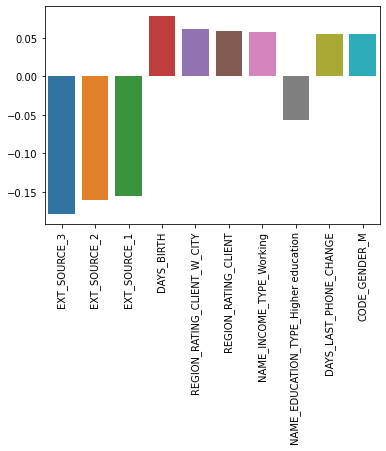

In [7]:
ax = sns.barplot(x=features_names, y=correlation_with_target)
for item in ax.get_xticklabels():
        item.set_rotation(90)

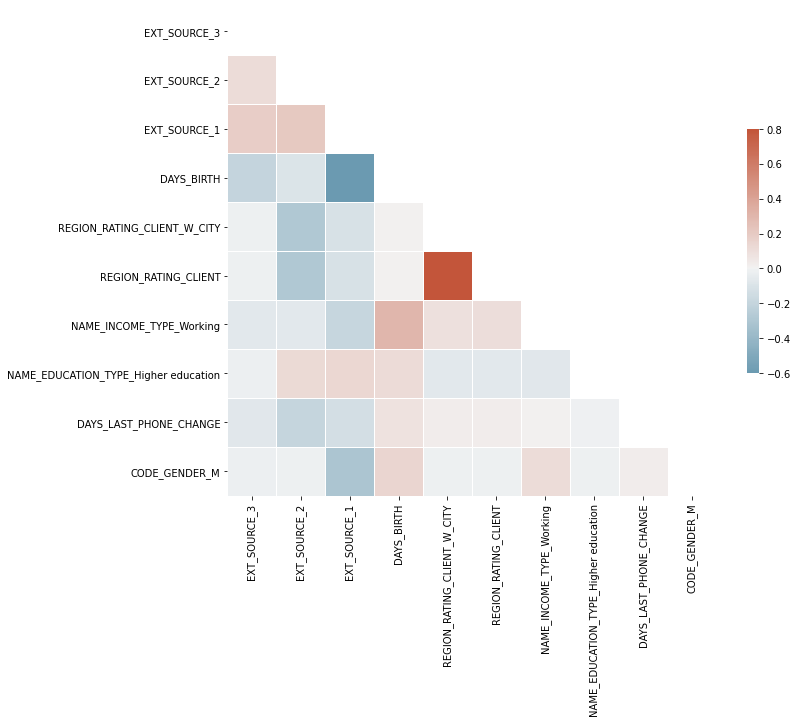

In [8]:
# affichage de la matrice de corrélation
short_df = pd.DataFrame(data=app_train, columns=features_names)
corr = short_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Valeurs manquantes

In [9]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
missing_values_t = missing_values_table(short_df)
missing_values_t.head(20)

Your selected dataframe has 10 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
EXT_SOURCE_1,173378,56.4
EXT_SOURCE_3,60965,19.8
EXT_SOURCE_2,660,0.2
DAYS_LAST_PHONE_CHANGE,1,0.0


Ces valeurs manquantes seront traitées par imputation au moment de la préparation des donnéés pour les modèles de learning.Une autre option serait d'enlever les colonnes contenant trop de données manquant mais on ne peut pas savoir si certaines aiedraient nos modèles à l'avance donc on garde tout.

### Traitement des valeurs aberrantes

In [10]:
if debug:
    for feat in features_names:
        if 'DAYS' in feat: # changing days to years
            print((app_train[feat] / -365).describe(), '\n')
        else:
            print(app_train[feat].describe(), '\n')

La seule colonne semblant présenter des valeurs aberrantes est "Days Employment". Ces valeurs sont remplacées par des NaN.

Text(0.5, 0, 'Days Employment')

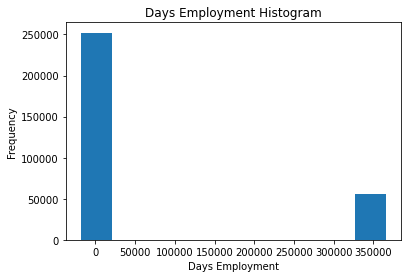

In [11]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

Text(0.5, 0, 'Days Employment')

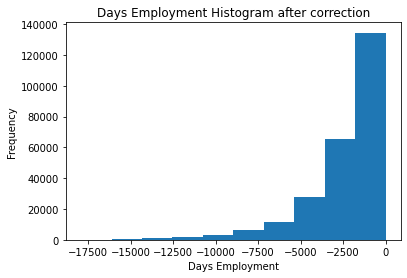

In [12]:
app_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram after correction')
plt.xlabel('Days Employment')

### Nouvelles variables

Les nouvelles variables sont le revenu effectif (salaire ajusté en fonction du nombre d'enfants), le ratio "mensualité / revenu" la durée de remboursement, et le ratio "temps travaillé / temps vécu".

In [13]:
extended_app_train = app_train.copy()
custom_features = ['EFFECTIVE_INCOME', 'CREDIT_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']
extended_app_train['EFFECTIVE_INCOME'] = extended_app_train['AMT_INCOME_TOTAL'] - 12 * 500 * extended_app_train['CNT_CHILDREN']
extended_app_train['CREDIT_INCOME_PERCENT'] = extended_app_train['AMT_CREDIT'] / extended_app_train['AMT_INCOME_TOTAL']
extended_app_train['CREDIT_TERM'] = extended_app_train['AMT_CREDIT'] / extended_app_train['AMT_ANNUITY']
extended_app_train['DAYS_EMPLOYED_PERCENT'] = extended_app_train['DAYS_EMPLOYED'] / (extended_app_train['DAYS_BIRTH'] - 5470)

In [14]:
for feature in custom_features:
    print(extended_app_train[feature].describe(), '\n')

count    3.075110e+05
mean     1.662956e+05
std      2.371069e+05
min     -3.900000e+04
25%      1.065000e+05
50%      1.440000e+05
75%      2.025000e+05
max      1.169940e+08
Name: EFFECTIVE_INCOME, dtype: float64 

count    307511.000000
mean          3.957570
std           2.689728
min           0.004808
25%           2.018667
50%           3.265067
75%           5.159880
max          84.736842
Name: CREDIT_INCOME_PERCENT, dtype: float64 

count    307499.000000
mean         21.612322
std           7.823823
min           8.036674
25%          15.614496
50%          20.000000
75%          27.099985
max          45.305079
Name: CREDIT_TERM, dtype: float64 

count    252137.000000
mean          0.114066
std           0.100364
min          -0.000000
25%           0.040040
50%           0.084510
75%           0.157361
max           0.596133
Name: DAYS_EMPLOYED_PERCENT, dtype: float64 



## Comparaison des modèles et synthèse

### Métriques

Différentes métriques seront utilisée pôur comparer les performances des modèles.
L'aire sous la courbe ROC donne une idée globale des performances du modèle.
La précision permet de déduire le taux de faux positifs (opportunités manquées).
Le rappel permet d'évaluer la non détection, qui est l'erreur la plus coûteuse pour la banque.
Et le f1 score est simplement la moyenne harmonique de la précision et du rappel.

In [15]:
_models = ["Regression Logistique", "Random Forest", "SVM à Noyau", "LGBM"]
model_probs = []
model_bin_probs = []
def metrics(models, predictors):
    aucs = []
    accs = []
    recalls = []
    fscores = []
    imps = []
    # random guessing
    ns_probs = [0 for _ in range(len(y_test))]
    ns_auc = roc_auc_score(y_test, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Hasard')
    # calculate and display models metrics
    for model, predictor in zip(models, predictors):
        if model != "SVM à Noyau":
            probs = predictor.predict_proba(X_test)[:, 1]
        else:
            probs = predictor.predict(X_test)
        model_probs.append(probs)
        bin_probs = list(map(lambda x: 1 if x>=probability_threshold else 0, probs))
        model_bin_probs.append(bin_probs)
        aucs.append(roc_auc_score(y_test, probs))
        accs.append(precision_score(y_test, bin_probs))
        recalls.append(recall_score(y_test, bin_probs))
        fscores.append(f1_score(y_test, bin_probs))
        if model == "Random Forest" or  model == "LGBM":
            imps.append(predictor.feature_importances_)
        elif model == "Regression Logistique":
            imps.append(predictor.coef_[0])
        else:
            imps.append(None)
        lr_fpr, lr_tpr, _ = roc_curve(y_test, probs)
        plt.plot(lr_fpr, lr_tpr, marker='.', label=model)
    res_data = {"Modèle": models, "ROC_AUC": aucs, "Précision": accs, "Recall": recalls, "F-score": fscores, "Importances": imps}
    result_df = pd.DataFrame(res_data)
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.legend()
    plt.show()
    return result_df


### Séparation du jeu de données et balance de la variable cible

Les données sont éventuellement samplées (en fonction du modèle).

Puis elles sont séparées en jeu d'entraînement et de test (cross validation).

L'imputation est réalisée avec la médiane des valeurs.

Les données sont normalisées.

La variable cible est très déséquilibrée donc elle est ré-équilibrée ici via SMOTE.

In [16]:
def split_data(df, subsample=0, showtarget=False):
    # sampling data for hyperparameters tuning
    if subsample:
        df = df.sample(frac=subsample, random_state=42)
        
    # train test split
    y = df['TARGET']
    X = df[features_names].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    
    # imputation
    imputer = SimpleImputer(strategy = 'median')
    scaler = MinMaxScaler(feature_range = (0, 1))

    imputer.fit(X_train)
    X_train = imputer.transform(X_train)
    X_test = imputer.transform(X_test)
    
    # noramlization
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # balance
    if showtarget:
        y_train.plot.hist(title = 'TARGET distribution')
        plt.show()
    pipeline = Pipeline(steps=[('o', SMOTE(sampling_strategy=0.8)), ('u', RandomUnderSampler(sampling_strategy=1))])
    X_train, y_train = pipeline.fit_resample(X_train, y_train)
    if showtarget:
        y_train.plot.hist(title = 'TARGET distribution after balance')
        plt.show()
    
    # smaller training set for kernel SVM
    lsX_train = []
    sy_train = y_train.copy()
    labels = []
    for i in range(len(X_train)):
        if i%10:
            labels.append(i)
        else:
            lsX_train.append(X_train[i])
    sy_train = sy_train.drop(labels=labels)
    sX_train = np.array(lsX_train)
    
    return y, X, X_train, X_test, y_train, y_test, sX_train, sy_train

### Tuning des hyperparamètres

Dans cette section on effectue des grid search pour optimiser les hyperparamètres de trois de nos modèles.

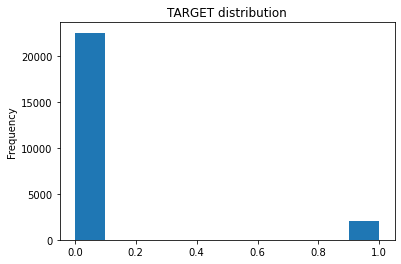

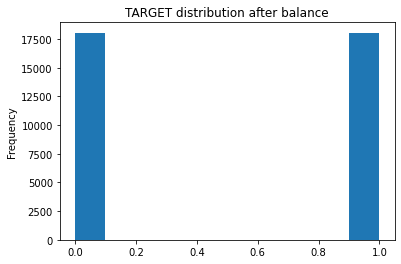

In [17]:
sy, sX, sX_train, sX_test, sy_train, sy_test, tmp1, tmp2 = split_data(app_train, subsample=0.1, showtarget=True)

In [18]:
# regression logistique
if not debug:
    grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]} # l1 lasso l2 ridge
    reglog=LogisticRegression()
    reglog_grid=GridSearchCV(reglog, grid, cv=10, scoring=evaluation_metric)
    reglog_grid.fit(sX_train, sy_train)
    print(reglog_grid.best_params_)
    print("accuracy :", reglog_grid.best_score_)
    reglog_params = reglog_grid.best_params_
else:
    reglog_params = {'C': 0.01, 'penalty': 'l2'}

{'C': 0.01, 'penalty': 'l2'}
accuracy : 0.669758532110108


In [19]:
# random forest
if not debug:
    rfc=RandomForestClassifier(random_state=42)
    param_grid = { 
        'n_estimators': [100, 1000],
        'max_features': ['sqrt', 'log2']
    }
    forest_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring=evaluation_metric, n_jobs=-1)
    forest_grid.fit(sX_train, sy_train)
    print(forest_grid.best_params_)
    print("accuracy :", forest_grid.best_score_)
    forest_params = forest_grid.best_params_
else:
    forest_params = {'max_features': 'sqrt', 'n_estimators': 1000}

{'max_features': 'sqrt', 'n_estimators': 1000}
accuracy : 0.8892904667826335


In [20]:
# SVM à noyau
if not debug:
    param_grid = {'C': [1, 1000], 
                  'gamma': [1, 0.01, 0.0001],
                  'kernel': ['rbf']} 
    svm_grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=0, scoring=evaluation_metric, cv=2, n_jobs=-1)
    svm_grid.fit(sX_train, sy_train)
    print(svm_grid.best_params_)
    print("accuracy :", svm_grid.best_score_)
    svm_params = svm_grid.best_params_
else:
    svm_params = {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}

{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
accuracy : 0.7743276279859772


### Regression Logistique

In [21]:
def make_reg_log(X_tr, y_tr):
    print("Training logistic regression")
    reg_log = LogisticRegression(C=reglog_params['C'], penalty=reglog_params['penalty'], n_jobs=-1)
    reg_log.fit(X_tr, y_tr)
    return reg_log

### Random Forest

In [22]:
def make_random_forest(X_tr, y_tr):
    print("Training random forest")
    random_forest = RandomForestClassifier(
        n_estimators=forest_params['n_estimators'],
        random_state=50,
        max_features=forest_params['max_features'],
        verbose=False,
        n_jobs=-1)
    res = random_forest.fit(X_tr, y_tr)
    return random_forest

### SVM à Noyau

In [23]:
def make_kernel_SVM(X_tr, y_tr):
    print("Training kernel SVM")
    svm_classifier = svm.SVC(kernel='rbf', gamma=svm_params['gamma'], C=svm_params['C'])
    svm_classifier.fit(X_tr, y_tr)
    return svm_classifier

### Gradient Boosting

In [24]:
def make_lgbm(X_tr, y_tr, X_te, y_te):
    print("Training Gradient Boosting Machine")
    # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=34,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.0222415,
        min_child_weight=39.3259775,
        silent=1,
        verbose=-1,
        n_jobs=-1)
    clf.fit(X_tr, y_tr, eval_set=(X_te, y_te), eval_metric=evaluation_metric, verbose=0, early_stopping_rounds=200)
    return clf

### Modèle de référence

In [25]:
y, X, X_train, X_test, y_train, y_test, sX_train, sy_train = split_data(app_train)
_predictors = [make_reg_log(X_train, y_train)]

Training logistic regression


In [26]:
_predictors.append(make_random_forest(X_train, y_train))

Training random forest


In [27]:
_predictors.append(make_kernel_SVM(sX_train, sy_train))

Training kernel SVM


In [28]:
_predictors.append(make_lgbm(X_train, y_train, X_test, y_test))

Training Gradient Boosting Machine


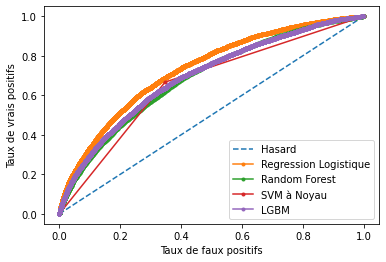

                  Modèle   ROC_AUC  Précision    Recall   F-score
0  Regression Logistique  0.732188   0.124053  0.814306  0.215307
1          Random Forest  0.688691   0.156826  0.474439  0.235731
2            SVM à Noyau  0.659585   0.143728  0.666801  0.236483
3                   LGBM  0.695586   0.135535  0.660942  0.224942


In [29]:
stats_df = metrics(_models, _predictors)
display_df = stats_df[["Modèle", "ROC_AUC", "Précision", "Recall", "F-score"]]
print(display_df)

### Modèle enrichi avec les nouvelles variables

In [30]:
features_names += custom_features
y, X, X_train, X_test, y_train, y_test, sX_train, sy_train = split_data(extended_app_train)
_predictors = [make_reg_log(X_train, y_train)]

Training logistic regression


In [31]:
_predictors.append(make_random_forest(X_train, y_train))

Training random forest


In [32]:
_predictors.append(make_kernel_SVM(sX_train, sy_train))

Training kernel SVM


In [33]:
_predictors.append(make_lgbm(X_train, y_train, X_test, y_test))

Training Gradient Boosting Machine


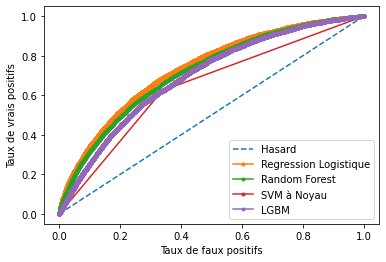

                  Modèle   ROC_AUC  Précision    Recall   F-score
0  Regression Logistique  0.735601   0.125355  0.811881  0.217177
1          Random Forest  0.719005   0.179380  0.478481  0.260937
2            SVM à Noyau  0.642584   0.138895  0.623358  0.227172
3                   LGBM  0.695116   0.177629  0.284300  0.218648


In [34]:
stats_df_extended = metrics(_models, _predictors)
display_df = stats_df_extended[["Modèle", "ROC_AUC", "Précision", "Recall", "F-score"]]
print(display_df)

On affiche la distribution des prédictions pour chaque modèle.

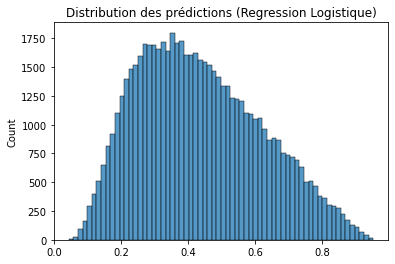

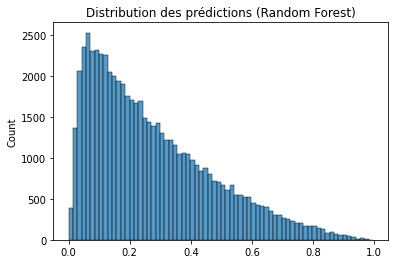

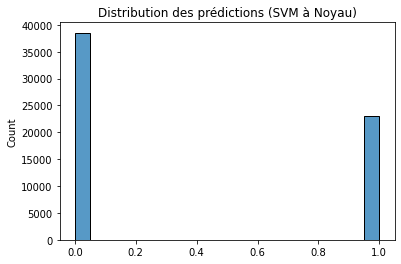

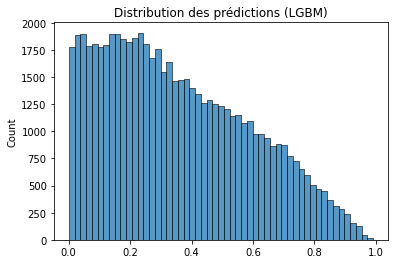

In [35]:
for model_id in range(4):
    sns.histplot(data=model_probs[model_id])
    plt.title(f'Distribution des prédictions ({_models[model_id]})')
    plt.show()

## Interprétabilité des modèles

Pour interpréter les modèles, nous représentons graphiquement l'importance des variables de chaque modèle (à l'exception de la SVM à noyau).
Pour la régression logistique, il s'agit de la valeur absolue des coefficients appliqués au différentes variables, qui sont donc représentatif de l'importance puisque les données ont été normalisées.
Pour la Random Forest, l'importance de Gini (ou Mean Decrease in Impurity) est utilisée. Elle calcule l'importance des variables en faisant la somme des arbres qui incluent cette variable pour chaque partition de données. Plus formellement, il s'agit de la moyenne de la diminution totale de l'impureté des noeuds, pondérée par la probabilité de les atteindre, pour chaque arbre de la forêt.

In [36]:
def display_importances(model_index):
    for feature_importance in [stats_df['Importances'].iloc[model_index], stats_df_extended['Importances'].iloc[model_index]]:
        feature_importance = list(map(abs, feature_importance))
        ordered_features, ordered_importance = [list(i) for i in zip(*sorted(zip(features_names, feature_importance), key=lambda x: -x[1]))]
        plt.figure(figsize=(8, 10))
        sns.barplot(x=ordered_importance, y=ordered_features)
        plt.title(f'Importance des variables ({_models[model_index]})')
        plt.tight_layout()
        plt.show()

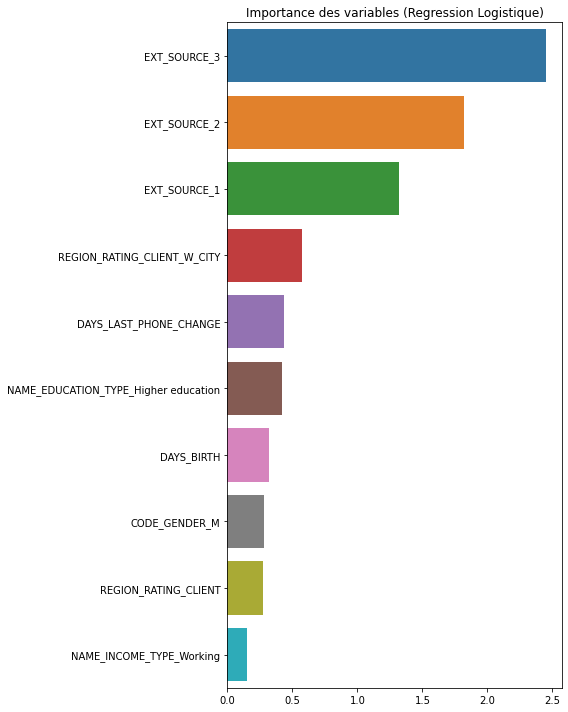

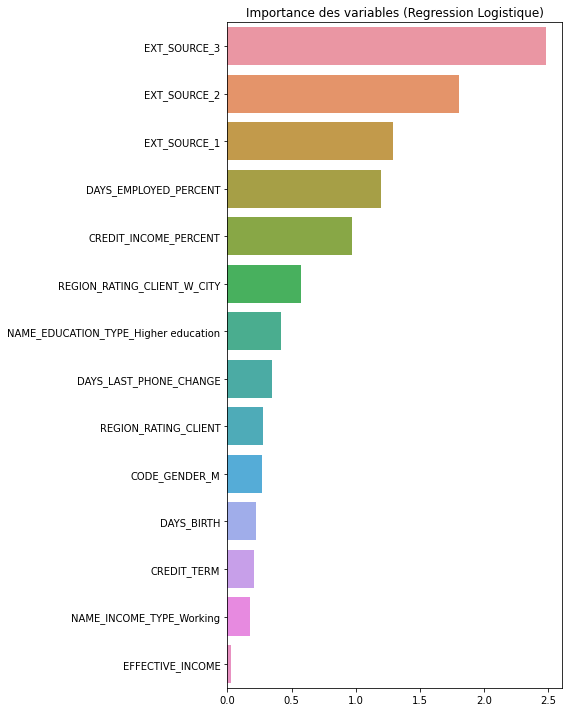

In [37]:
display_importances(0)

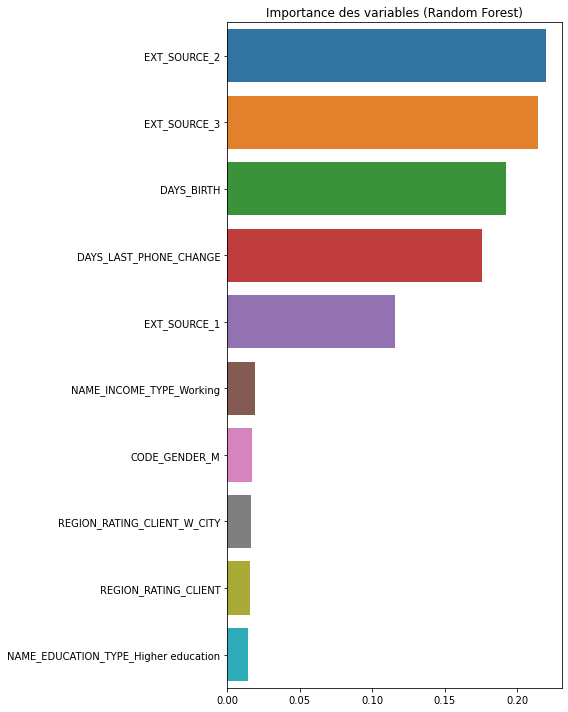

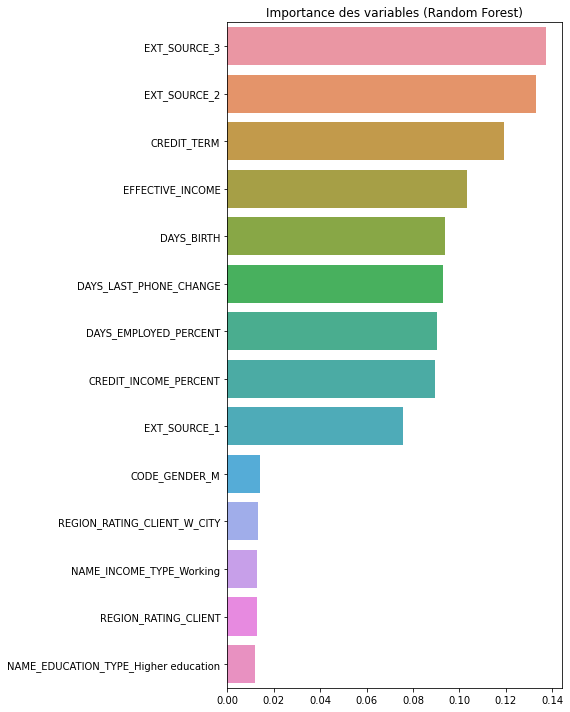

In [38]:
display_importances(1)

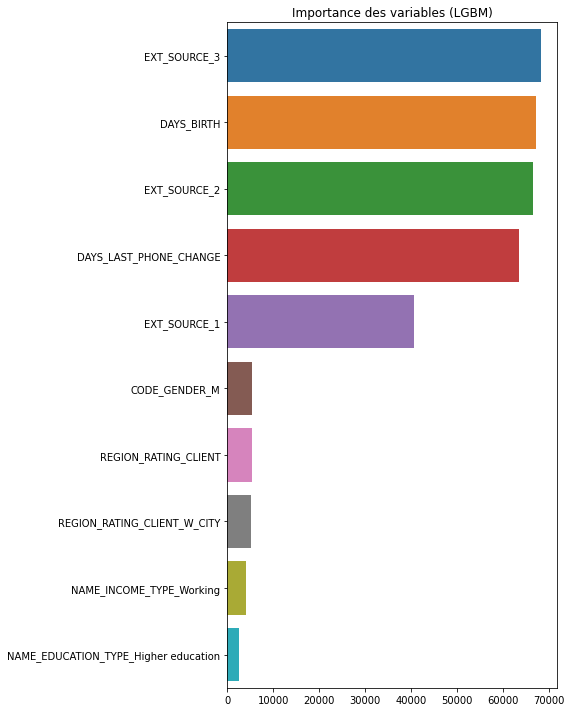

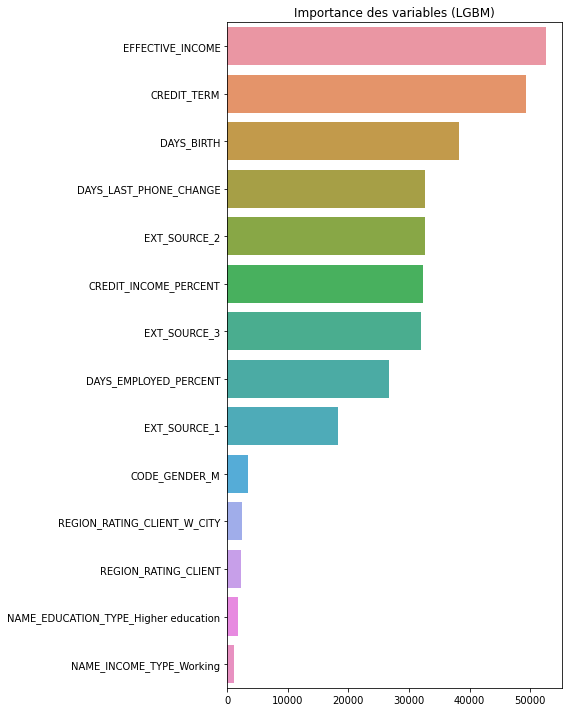

In [39]:
display_importances(3)